# Predicting Future Sales by the Teletubbies

In this notebook, we are looking to **predict future sales** for every store using historical data.

----

Mission brief:
*"You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge."*

To make our predictions, we will follow the OSEMN data science framework
1. **O**btain the data 
    * Load the prerequisite packages
    * Load the data
2. **S**crub the data
    * Identify data oddities
    * Identify missing values
3. **E**xplore the data
    * Examine the nature of the variables
    * Explore the time series data
    * Conduct feature engineering
4. **M**odel the data 
    * Create the model
    * Fine-tune the model
5. I**n**terpret the data

## Step \#1: Obtain the data

### Load the prerequisite packages

In [1]:
#Standard data science packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

### Load the data

In [2]:
#Check what files are in the input directory
import os
print(os.listdir("../input/competitive-data-science-predict-future-sales"))

['shops.csv', 'test.csv', 'sample_submission.csv', 'sales_train.csv', 'item_categories.csv', 'items.csv']


In [3]:
#Import the data
raw_sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
raw_items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
raw_shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
raw_test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
raw_sample = pd.read_csv("../input/competitive-data-science-predict-future-sales/sample_submission.csv")
raw_item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")

### Do some initial exploration of the data

#### Sales data

The training dataset contains a row for each item-shop combination by day and provides the items sold per day (item_cnt_day). Some questions to be validated:
- Is this unique by date x shop ID x item ID combination?
- Why are some values for item_cnt_day negative? Are these refunds?

In [4]:
df_sales  = raw_sales.copy()
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
df_sales.shape

(2935849, 6)

#### Submission data

The submission format is to provide item_cnt_month for each ID.

To be validated:
* What ID is this? 
    * KYY: ID is basically each corresponding row ID in the test dataset.
    
   
* What timeframe are we predicting item counts for (month or day or year?) - testing dataset only contains shop_id and item_id, no mention of date range. 

In [6]:
df_submission = raw_sample.copy()
df_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [7]:
df_test = raw_test.copy()
df_test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


## Step \#2: Scrub the data 

### Join the reference data to the sales data

#### First join: shop data

We will join the shop data to the sales data. We will perform a left join and we will check that there are no duplicated rows.

In [8]:
df_shops = raw_shops.copy(deep = True)
print("Dataframe size: ", df_shops.shape)
df_shops.head()

Dataframe size:  (60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
df_sales2 = pd.merge(left = df_sales, right = df_shops, on = 'shop_id')
print("Pre-join row count:", len(df_sales.index))
print("Post-join row count:", len(df_sales2.index))
if len(df_sales.index) == len(df_sales2.index):
    print("You're safe - no row duplication found!")
else: 
    print("WARNING: Rows have been duplicated!")
df_sales2.head()

Pre-join row count: 2935849
Post-join row count: 2935849
You're safe - no row duplication found!


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир"""
1,10.01.2013,0,59,22151,399.0,1.0,"Ярославль ТЦ ""Альтаир"""
2,04.01.2013,0,59,5603,699.0,1.0,"Ярославль ТЦ ""Альтаир"""
3,19.01.2013,0,59,5587,199.0,2.0,"Ярославль ТЦ ""Альтаир"""
4,31.01.2013,0,59,5613,5571.0,1.0,"Ярославль ТЦ ""Альтаир"""


#### Next set of joins: item and item categories data

Next, we will add the item names and item categories to the sales data 

In [10]:
df_items = raw_items.copy(deep = True)
print("Dataframe size: ", df_items.shape)
df_items.head()

Dataframe size:  (22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
df_item_categories = raw_item_categories.copy(deep = True)
print("Dataframe size: ", df_item_categories.shape)
df_item_categories.head()

Dataframe size:  (84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
df_items2 = pd.merge(left = df_items, right = df_item_categories, on = 'item_category_id')
print("Pre-join row count:", len(df_items.index))
print("Post-join row count:", len(df_items2.index))
if len(df_items.index) == len(df_items2.index):
    print("You're safe - no row duplication found!")
else: 
    print("WARNING: Rows have been duplicated!")
df_items2.head()

Pre-join row count: 22170
Post-join row count: 22170
You're safe - no row duplication found!


,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [13]:
df_sales3 = pd.merge(left = df_sales2, right = df_items2, on = 'item_id')
print("Pre-join row count:", len(df_sales2.index))
print("Post-join row count:", len(df_sales3.index))
if len(df_sales2.index) == len(df_sales3.index):
    print("You're safe - no row duplication found!")
else: 
    print("WARNING: Rows have been duplicated!")
df_sales3.head()

Pre-join row count: 2935849
Post-join row count: 2935849
You're safe - no row duplication found!


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


### Check for oddities in the data
-------

#### Findings
* ~75% of the rows have 1 in the item_cnt_day column
* The minimum value in item_cnt_day column is -2.2
* The highest value in item_cnt_day column is 2,169

In [14]:
df_sales3.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


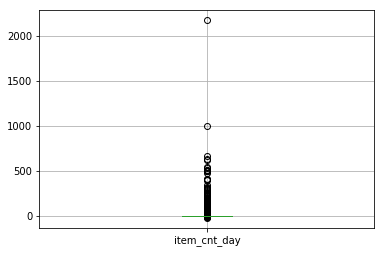

In [15]:
boxplot = df_sales3.boxplot(column ='item_cnt_day')

### Check for missing values

---

#### Findings
* There are no missing values in the cells

In [16]:
#Check if there are any NaNs in the data by converting all sales to Booleans and seeing if any are 1
df_sales3.isnull().values.any()

False

## Step \#3: Explore the data

### Examine the variables

We should explore the nature of the static data such as the number of products by item category and by store.

### Summary of dataset 

Data from 01/01/2013 to 31/12/2015 (total of 3 years of data)
* Total number of items ordered for each store seem to be decreasing over the years

#### Shops
*  60 shops in total (0 to 59)

#### Items
*  22,170 items in total (from 0 to 22,169)

#### Item Categories
*  84 item categories in total (from 0 to 83)

In [17]:
# Add in new column 'date2' thats bascially 'date' column but as timestamp
df_sales3['date2']=pd.to_datetime(df_sales3['date'])

In [18]:
# Check how much data we have in terms of timeframe
df_sales3['date2'].describe()

count                 2935849
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-12-10 00:00:00
Name: date2, dtype: object

In [19]:
# Look at number of shops
df_shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [20]:
# Look at number of items and categories
df_items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [21]:
# Group the items df by the item category id
items_per_cat = df_items2.groupby(['item_category_id']).count()

# Sort the item categories by the number of items in them in descending order
items_per_cat = items_per_cat.sort_values(by = 'item_id', ascending = False)

# Filter only the top 10 item categories
items_per_cat = items_per_cat.iloc[0:20].reset_index()
items_per_cat.head()

,item_category_id,item_name,item_id,item_category_name
0,40,5035,5035,5035
1,55,2365,2365,2365
2,37,1780,1780,1780
3,31,1125,1125,1125
4,58,790,790,790


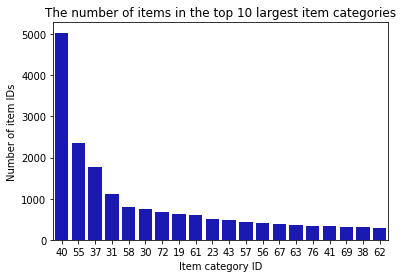

In [22]:
plt.figure()
ax = sns.barplot(data = items_per_cat, x = 'item_category_id', y = 'item_id', color = "mediumblue", order = items_per_cat.item_category_id)
plt.title("The number of items in the top 10 largest item categories")
plt.ylabel("Number of item IDs")
plt.xlabel("Item category ID")
plt.show()

In [23]:
# Get total distinct items, item categories and total number of items for each shop over the 3 year time frame
items_per_shop =df_sales3.assign(
    total_distinct_items=df_sales3['item_id'],
    total_item_counts_day=df_sales3['item_cnt_day'],
    total_item_categories=df_sales3['item_category_id']
).groupby(['shop_id']).agg(dict(total_distinct_items=pd.Series.nunique, total_item_counts_day=np.sum, total_item_categories=pd.Series.nunique) ).reset_index()

items_per_shop.head()

,shop_id,total_distinct_items,total_item_counts_day,total_item_categories
0,0,3600,11705.0,48
1,1,2523,6311.0,41
2,2,4849,30620.0,59
3,3,5261,28355.0,58
4,4,7309,43942.0,61


In [24]:
### add in a year and month column
df_sales3['year'] = df_sales3['date2'].dt.year
df_sales3['month'] = df_sales3['date2'].dt.month

In [25]:
# Get total distinct items, item categories and total number of items for each shop per year
items_per_shop_year =df_sales3.assign(
    total_distinct_items=df_sales3['item_id'],
    total_item_counts_day=df_sales3['item_cnt_day'],
    total_item_categories=df_sales3['item_category_id']
).groupby(['shop_id', 'year']).agg(dict(total_distinct_items=pd.Series.nunique, total_item_counts_day=np.sum, total_item_categories=pd.Series.nunique) ).reset_index()

items_per_shop_year.head()

,shop_id,year,total_distinct_items,total_item_counts_day,total_item_categories
0,0,2013,3600,11705.0,48
1,1,2013,2523,6311.0,41
2,2,2013,2407,9961.0,52
3,2,2014,2264,12221.0,51
4,2,2015,2014,8438.0,49


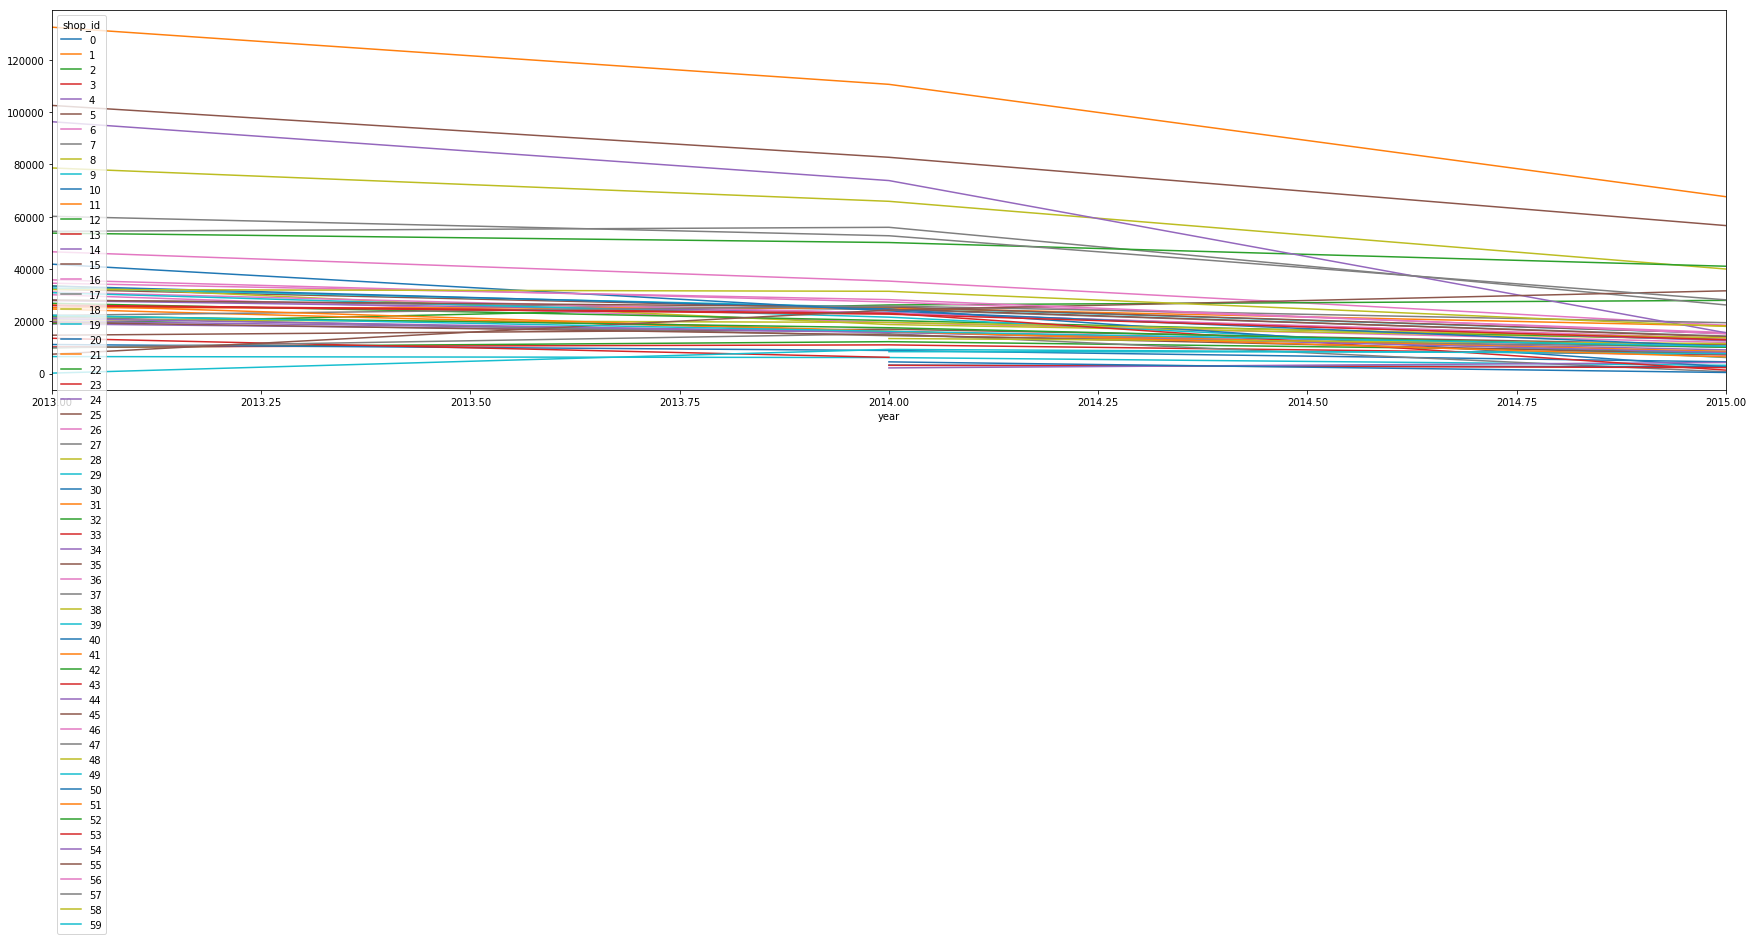

In [26]:
## plotting the number of items per shop in each year to see if theres a general YOY growth

fig, ax = plt.subplots(figsize=(30,7))
df_sales3.groupby(['year','shop_id']).sum()['item_cnt_day'].unstack().plot(ax=ax)


### Explore the time series data

As this is sales data, we should examine how it varies over time and how it varies by product.